In [1]:
from random import randint, random, sample
import collections
import os
import shutil

import numpy as np
import math
import time
from collections import deque
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import sklearn.neighbors
import sklearn.metrics
import sklearn.mixture
import matplotlib.pyplot as plt
import PIL
from nvidia.dali.plugin.pytorch import DALIGenericIterator

from imageComponent import *
from remote_read_write import scp_read_wrapper, scp_write_wrapper
scp_Tload = scp_read_wrapper(T.load, 'ly_1112103017@172.16.35.121', 30907, '/public/ly/zyz/cluster_id_rsa', '/public/ly/zyz/imageCL/tmp')
scp_Tsave = scp_write_wrapper(T.save, 'ly_1112103017@172.16.35.121', 30907, '/public/ly/zyz/cluster_id_rsa', '/public/ly/zyz/imageCL/tmp')

dali_device = 2
device = 'cuda:1'
T.backends.cudnn.benchmark = True
T.backends.cudnn.deterministic = True
use_amp = False

/public/ly/anaconda3/envs/zyz/lib/python3.10/site-packages/nvidia/dali/backend.py:46: Warning: DALI support for Python 3.10 is experimental and some functionalities may not work.
  deprecation_warning("DALI support for Python 3.10 is experimental and some functionalities "


In [2]:
def sample_tsne(X, class_y, num, perplexity):
    with T.inference_mode():
        ridx = sample(range(len(X)), num)
        nX = X[ridx]
        nX -= nX.min()
        nX /= nX.max()
        tnX = tsne(nX, 2, 50, perplexity=perplexity)
        return tnX.cpu().numpy(), class_y[ridx].cpu().numpy()

for model in ['Res18', 'Res101', 'ViT']:
    (X, y, sX, sy, class_y) = T.load('/public/ly/zyz/imageCL/feature/%s.pth' %(model))
    for p in [25, 2500, 24900]:
        if model == 'Res18' and (p == 25 or p==2500):
            continue
        print(model, p)
        tnX, tny = sample_tsne(X, class_y, 25000, p)
        stnX, stny = sample_tsne(sX, class_y, 25000, p)
        T.save((tnX, tny, stnX, stny), '/public/ly/zyz/imageCL/feature/%s%d.pth' %(model, p))

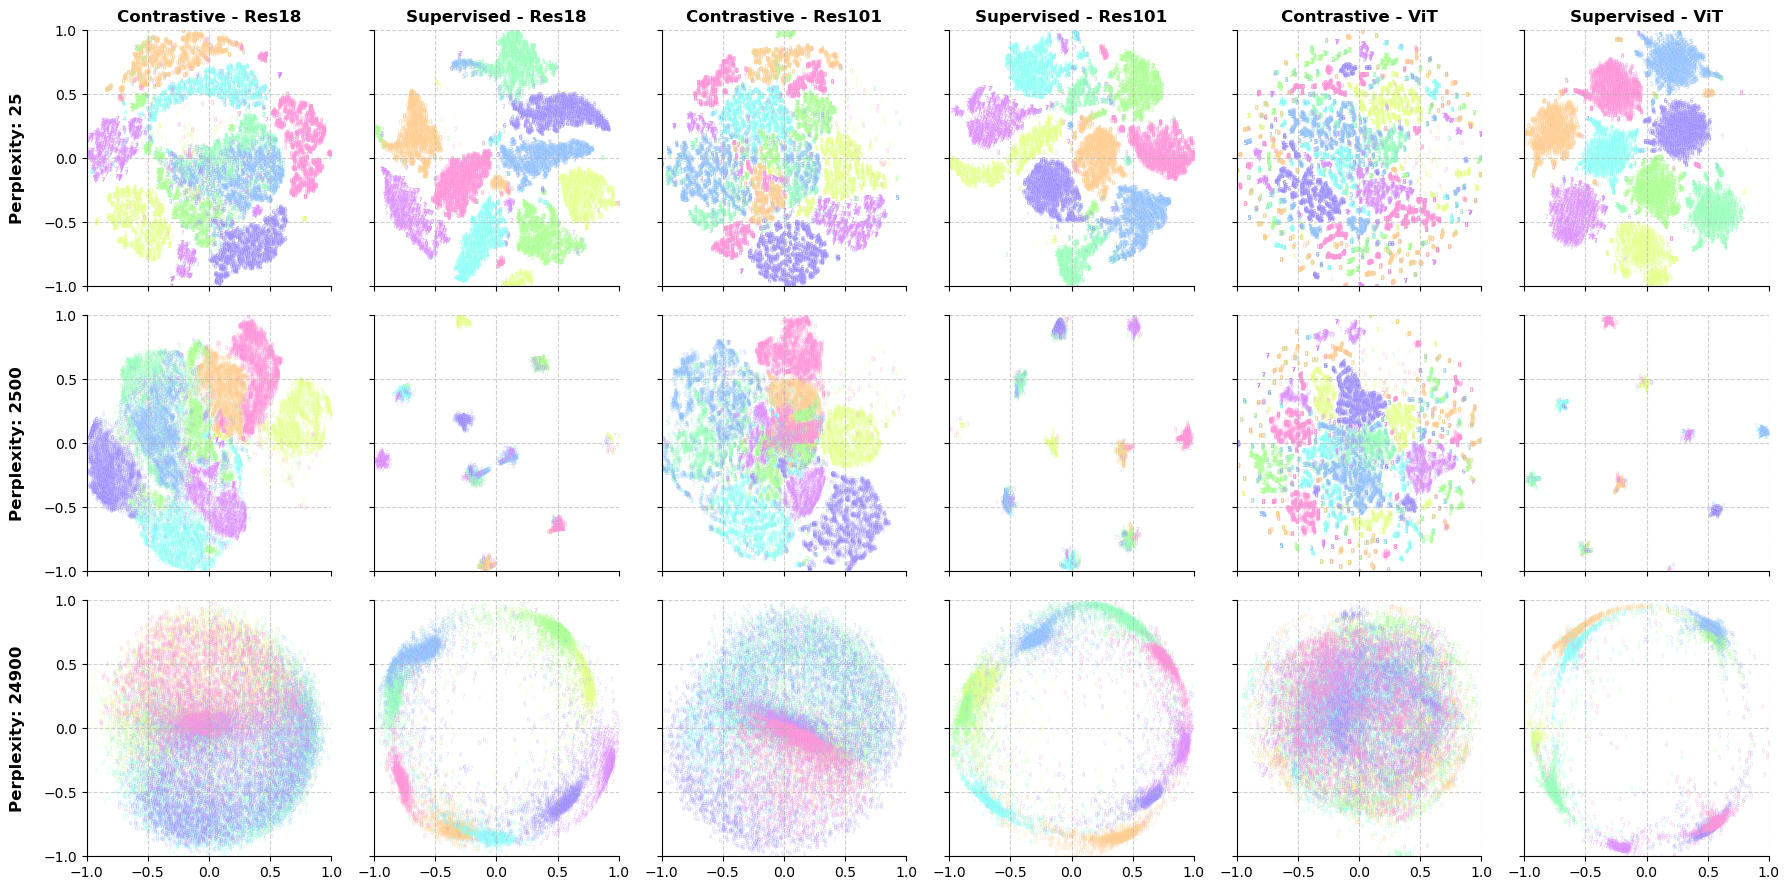

In [48]:
def plot_scatter(X, y, ax):
    X /= ((X.max(axis=0) - X.min(axis=0)) / 2)
    X -= (X.min(axis=0) + 1)
    palette = sns.color_palette("hsv", y.max())
    for i in range(y.max()):
        idx = y == i
        sns.scatterplot(x=X[idx, 0], y=X[idx, 1], alpha=0.2, ax=ax, s=10, color=palette[i], marker=f"${i}$")
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_xticks(np.arange(-1, 1.1, 0.5))
        ax.set_yticks(np.arange(-1, 1.1, 0.5))

fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharex='col', sharey='row')

models = ['Res18', 'Res101', 'ViT']
perplexities = [25, 2500, 24900]

for i, model in enumerate(models):
    for j, perplexity in enumerate(perplexities):
        tnX, tny, stnX, stny = T.load('/public/ly/zyz/imageCL/feature/%s%d.pth' %(model, perplexity))
        plot_scatter(tnX, tny, axes[j, i*2])
        plot_scatter(stnX, stny, axes[j, i*2+1])
        axes[j, i*2].grid(True, linestyle='--', alpha=0.6)
        axes[j, i*2+1].grid(True, linestyle='--', alpha=0.6)
        axes[j, i*2].spines['right'].set_visible(False)
        axes[j, i*2].spines['top'].set_visible(False)
        axes[j, i*2+1].spines['right'].set_visible(False)
        axes[j, i*2+1].spines['top'].set_visible(False)

# Setting the title for columns
for i, model in enumerate(models):
    axes[0, i*2].set_title('Contrastive - %s' % model, fontsize=12, fontweight='bold')
    axes[0, i*2+1].set_title('Supervised - %s' % model, fontsize=12, fontweight='bold')

# Setting the label for rows
for i, perplexity in enumerate(perplexities):
    axes[i, 0].annotate('Perplexity: %d' % perplexity, xy=(0, 0.5), xytext=(-axes[i,0].yaxis.labelpad - 5, 0),
                        xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=90, fontweight='bold')

plt.tight_layout()
plt.savefig("test.png", dpi=600,format="png")
plt.show()